# Phase 2 ML Components Test

Test DiNOv2 embedder, PCA projector, and metrics module.

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import yaml

# Add src to path
sys.path.append(str(Path.cwd().parent))

from src.data_generation.parameter_sampler import ParameterSampler
from src.data_generation.void_generator import VoidGenerator
from src.embedding.dinov2_embedder import DinoV2Embedder
from src.embedding.pca_projector import PCAProjector
from src.optimization.metrics import compute_all_metrics

## 1. Generate Sample Images

Generate real, close, and far distributions as per config

In [2]:
# Load config
config_path = Path("../configs/experiment_config.yaml")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

BASE_SEED = config['random_seed']
print(f"Using master seed: {BASE_SEED}")

Using master seed: 1


In [3]:
# Initialize components
sampler = ParameterSampler()
base_image_dir = Path("../data/base_chips")
generator = VoidGenerator(base_image_dir)

Loaded 5 base chip images


In [4]:
# Generate small batches for testing
# Real: 3 param sets × 2 replications = 6 images
# Close: 3 param sets × 2 replications = 6 images
# Far: 3 param sets × 2 replications = 6 images
n_sets = 80
real_params = sampler.sample_parameter_sets('real', n_sets=n_sets, seed=BASE_SEED)
close_params = sampler.sample_parameter_sets('close', n_sets=n_sets, seed=BASE_SEED + 100)
far_params = sampler.sample_parameter_sets('far', n_sets=n_sets, seed=BASE_SEED + 200)

real_images, real_metadata = generator.generate_batch(real_params, replications=2, seed_offset=0)
close_images, close_metadata = generator.generate_batch(close_params, replications=2, seed_offset=1000)
far_images, far_metadata = generator.generate_batch(far_params, replications=2, seed_offset=2000)

print(f"Generated {len(real_images)} real, {len(close_images)} close, {len(far_images)} far images")

Generated 160 real, 160 close, 160 far images


## 2. Test DiNOv2 Embedder

Extract embeddings for all generated images

In [5]:
# Initialize embedder (this will download the model on first run)
embedder = DinoV2Embedder(model_name="dinov2_vitb14")
print(f"Embedding dimension: {embedder.embedding_dim}")

Using MPS (Metal Performance Shaders) device
Loading dinov2_vitb14 model...


Using cache found in /Users/ranhomri/.cache/torch/hub/facebookresearch_dinov2_main
/Users/ranhomri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/ranhomri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/ranhomri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded successfully
Embedding dimension: 768
Embedding dimension: 768


In [6]:
# Extract embeddings for each distribution
print("\nExtracting embeddings...")
real_embeddings = embedder.embed_batch(real_images, batch_size=8)
close_embeddings = embedder.embed_batch(close_images, batch_size=8)
far_embeddings = embedder.embed_batch(far_images, batch_size=8)

print(f"\nReal embeddings shape: {real_embeddings.shape}")
print(f"Close embeddings shape: {close_embeddings.shape}")
print(f"Far embeddings shape: {far_embeddings.shape}")


Extracting embeddings...
Extracting embeddings for 160 images (batch_size=8)...
  Processed 40/160 images
  Processed 80/160 images
  Processed 120/160 images
  Processed 160/160 images
Extracted embeddings shape: (160, 768)
Extracting embeddings for 160 images (batch_size=8)...
  Processed 40/160 images
  Processed 80/160 images
  Processed 120/160 images
  Processed 160/160 images
Extracted embeddings shape: (160, 768)
Extracting embeddings for 160 images (batch_size=8)...
  Processed 40/160 images
  Processed 80/160 images
  Processed 120/160 images
  Processed 160/160 images
Extracted embeddings shape: (160, 768)

Real embeddings shape: (160, 768)
Close embeddings shape: (160, 768)
Far embeddings shape: (160, 768)


In [7]:
# Combine all embeddings for PCA fitting (simulating iteration 0)
all_embeddings = np.vstack([real_embeddings, close_embeddings, far_embeddings])
print(f"Combined embeddings shape: {all_embeddings.shape}")

# Stage 1: Fit PCA to reduce to 400 dimensions (for optimization)
print("\n=== Stage 1: Reduce to 400D for optimization ===")
pca_embedding = PCAProjector(n_components=400)
all_embeddings_400d = pca_embedding.fit_transform(all_embeddings)
print(f"Reduced embeddings shape: {all_embeddings_400d.shape}")
print(f"Total explained variance (400D): {pca_embedding.explained_variance_ratio_.sum():.4f}")

Combined embeddings shape: (480, 768)

=== Stage 1: Reduce to 400D for optimization ===
Fitting PCA with 400 components on 480 samples...
PCA fitted successfully
Total explained variance: 0.9993
Reduced embeddings shape: (480, 400)
Total explained variance (400D): 0.9993


In [8]:
# Project each distribution to 400D (these are the "embeddings" for optimization)
real_embeddings_400d = pca_embedding.transform(real_embeddings)
close_embeddings_400d = pca_embedding.transform(close_embeddings)
far_embeddings_400d = pca_embedding.transform(far_embeddings)

print(f"Real 400D shape: {real_embeddings_400d.shape}")
print(f"Close 400D shape: {close_embeddings_400d.shape}")
print(f"Far 400D shape: {far_embeddings_400d.shape}")

# Stage 2: Fit another PCA on 400D to reduce to 2D (for visualization only)
print("\n=== Stage 2: Reduce to 2D for visualization ===")
pca_viz = PCAProjector(n_components=2)
all_viz_2d = pca_viz.fit_transform(all_embeddings_400d)

# Project each distribution to 2D
real_pca = pca_viz.transform(real_embeddings_400d)
close_pca = pca_viz.transform(close_embeddings_400d)
far_pca = pca_viz.transform(far_embeddings_400d)

print(f"\nReal 2D shape: {real_pca.shape}")
print(f"Close 2D shape: {close_pca.shape}")
print(f"Far 2D shape: {far_pca.shape}")

Real 400D shape: (160, 400)
Close 400D shape: (160, 400)
Far 400D shape: (160, 400)

=== Stage 2: Reduce to 2D for visualization ===
Fitting PCA with 2 components on 480 samples...
PCA fitted successfully
Total explained variance: 0.3514

Real 2D shape: (160, 2)
Close 2D shape: (160, 2)
Far 2D shape: (160, 2)


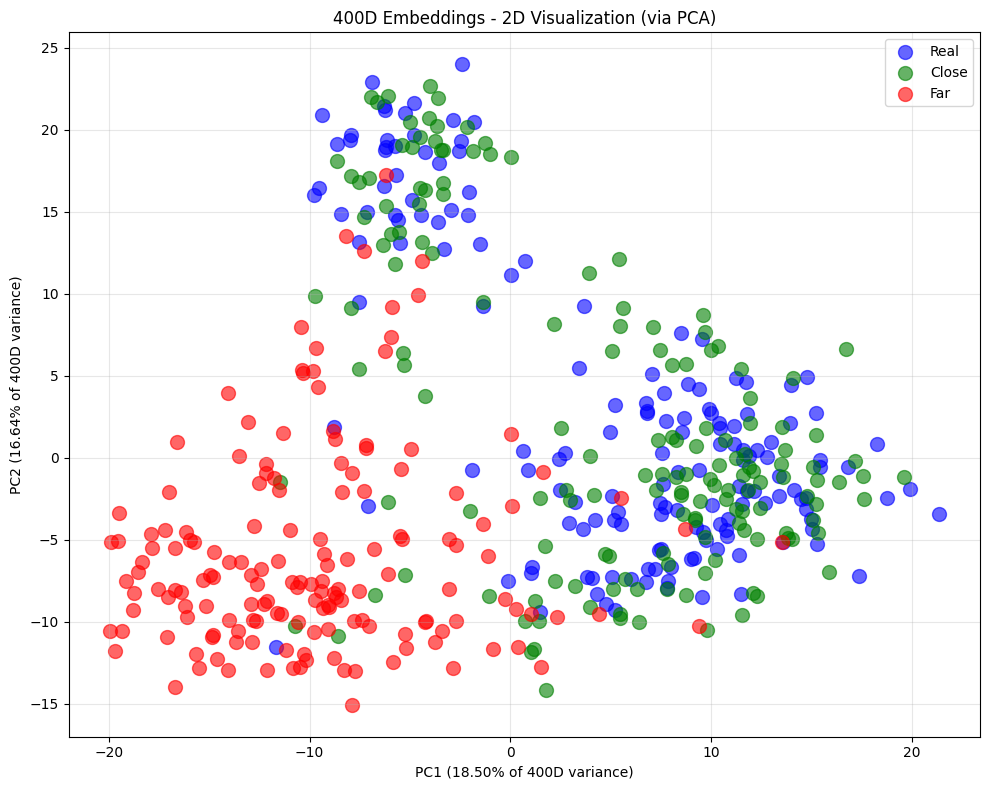


Note: This 2D visualization is from 400D embeddings
Total variance explained by 400D: 0.9993
Variance captured by 2D viz: 0.3514 of 400D variance


In [9]:
# Visualize 2D projections (from 400D embeddings)
plt.figure(figsize=(10, 8))
plt.scatter(real_pca[:, 0], real_pca[:, 1], c='blue', label='Real', alpha=0.6, s=100)
plt.scatter(close_pca[:, 0], close_pca[:, 1], c='green', label='Close', alpha=0.6, s=100)
plt.scatter(far_pca[:, 0], far_pca[:, 1], c='red', label='Far', alpha=0.6, s=100)
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.2%} of 400D variance)')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.2%} of 400D variance)')
plt.title('400D Embeddings - 2D Visualization (via PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNote: This 2D visualization is from 400D embeddings")
print(f"Total variance explained by 400D: {pca_embedding.explained_variance_ratio_.sum():.4f}")
print(f"Variance captured by 2D viz: {pca_viz.explained_variance_ratio_.sum():.4f} of 400D variance")

In [10]:
# Save both PCA models
pca_embedding_save_path = Path("../data/test_pca_embedding_400d.pkl")
pca_viz_save_path = Path("../data/test_pca_viz_2d.pkl")

pca_embedding.save(pca_embedding_save_path)
pca_viz.save(pca_viz_save_path)

# Load and verify
pca_embedding_loaded = PCAProjector.load(pca_embedding_save_path)
pca_viz_loaded = PCAProjector.load(pca_viz_save_path)

# Verify loaded PCAs work
real_400d_loaded = pca_embedding_loaded.transform(real_embeddings)
print(f"\nLoaded 400D PCA projection shape: {real_400d_loaded.shape}")
print(f"400D projections match: {np.allclose(real_embeddings_400d, real_400d_loaded)}")

real_2d_loaded = pca_viz_loaded.transform(real_embeddings_400d)
print(f"\nLoaded 2D PCA projection shape: {real_2d_loaded.shape}")
print(f"2D projections match: {np.allclose(real_pca, real_2d_loaded)}")

PCA model saved to ../data/test_pca_embedding_400d.pkl
PCA model saved to ../data/test_pca_viz_2d.pkl
PCA model loaded from ../data/test_pca_embedding_400d.pkl
Total explained variance: 0.9993
PCA model loaded from ../data/test_pca_viz_2d.pkl
Total explained variance: 0.3514

Loaded 400D PCA projection shape: (160, 400)
400D projections match: True

Loaded 2D PCA projection shape: (160, 2)
2D projections match: True


In [11]:
# Compare close vs real using 400D embeddings (what optimizer will use)
print("=== Metrics on 400D Embeddings ===")
print("\n--- Close vs Real ---")
close_vs_real_metrics = compute_all_metrics(close_embeddings_400d, real_embeddings_400d)
for key, value in close_vs_real_metrics.items():
    print(f"{key}: {value:.4f}")

print("\n--- Far vs Real ---")
far_vs_real_metrics = compute_all_metrics(far_embeddings_400d, real_embeddings_400d)
for key, value in far_vs_real_metrics.items():
    print(f"{key}: {value:.4f}")

=== Metrics on 400D Embeddings ===

--- Close vs Real ---
mmd_rbf: 0.0696
mmd_linear: 2.4786
wasserstein: 0.0850
syn_to_real_mean: 18.3061
real_to_syn_mean: 18.1901
max_nn_distance: 18.3061
mean_nn_distance: 18.2481
real_to_syn_max: 26.7647
unique_real_neighbors: 85.0000
median_nn_distance: 18.0237
coverage: 1.0000
threshold: 31.3281
mean_distance: 18.3061
median_distance: 18.0237
within_threshold_count: 160.0000

--- Far vs Real ---
mmd_rbf: 0.4261
mmd_linear: 17.4325
wasserstein: 0.1500
syn_to_real_mean: 21.5581
real_to_syn_mean: 22.2956
max_nn_distance: 22.2956
mean_nn_distance: 21.9269
real_to_syn_max: 32.2112
unique_real_neighbors: 34.0000
median_nn_distance: 21.3577
coverage: 1.0000
threshold: 31.3281
mean_distance: 21.5581
median_distance: 21.3577
within_threshold_count: 160.0000


## 5. Test Metrics Module

Calculate distribution similarity and sample-level metrics

In [12]:
# Summary block update
print("## Summary\\n")
print("Phase 2 ML components are working:")
print("- ✅ DiNOv2 embedder extracts 768-dim embeddings")
print("- ✅ PCA Stage 1: Reduces to 400-dim for optimization")
print(f"    • Explains {pca_embedding.explained_variance_ratio_.sum():.2%} of original variance")
print("- ✅ PCA Stage 2: Reduces to 2D for visualization")
print(f"    • Explains {pca_viz.explained_variance_ratio_.sum():.2%} of 400D variance")
print("- ✅ PCA save/load works for both stages")
print("- ✅ Metrics calculate on 400D embeddings")
print("- ✅ Visualizations show clear separation between distributions")

## Summary\n
Phase 2 ML components are working:
- ✅ DiNOv2 embedder extracts 768-dim embeddings
- ✅ PCA Stage 1: Reduces to 400-dim for optimization
    • Explains 99.93% of original variance
- ✅ PCA Stage 2: Reduces to 2D for visualization
    • Explains 35.14% of 400D variance
- ✅ PCA save/load works for both stages
- ✅ Metrics calculate on 400D embeddings
- ✅ Visualizations show clear separation between distributions


In [13]:
# Visualize metrics comparison
import pandas as pd

metrics_df = pd.DataFrame({
    'Close vs Real': close_vs_real_metrics,
    'Far vs Real': far_vs_real_metrics
}).T

print("\nMetrics Comparison:")
print(metrics_df[['mmd_rbf', 'wasserstein', 'mean_nn_distance', 'coverage']])


Metrics Comparison:
                mmd_rbf  wasserstein  mean_nn_distance  coverage
Close vs Real  0.069616     0.084955         18.248068       1.0
Far vs Real    0.426056     0.149979         21.926898       1.0


## 6. Visualize Sample Images with Embeddings

Show a few images from each distribution with their PCA coordinates

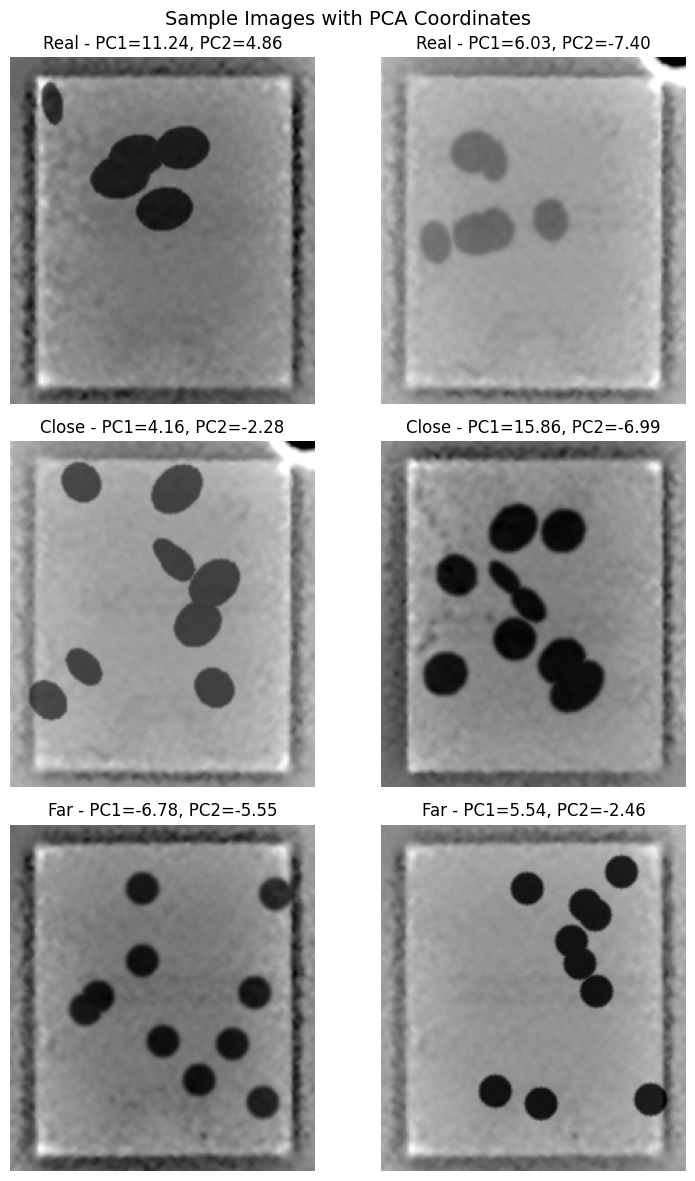

In [14]:
# Show first 2 images from each distribution
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
fig.suptitle('Sample Images with PCA Coordinates', fontsize=14)

for col_idx in range(2):
    # Real
    axes[0, col_idx].imshow(real_images[col_idx], cmap='gray')
    axes[0, col_idx].set_title(f'Real - PC1={real_pca[col_idx, 0]:.2f}, PC2={real_pca[col_idx, 1]:.2f}')
    axes[0, col_idx].axis('off')
    
    # Close
    axes[1, col_idx].imshow(close_images[col_idx], cmap='gray')
    axes[1, col_idx].set_title(f'Close - PC1={close_pca[col_idx, 0]:.2f}, PC2={close_pca[col_idx, 1]:.2f}')
    axes[1, col_idx].axis('off')
    
    # Far
    axes[2, col_idx].imshow(far_images[col_idx], cmap='gray')
    axes[2, col_idx].set_title(f'Far - PC1={far_pca[col_idx, 0]:.2f}, PC2={far_pca[col_idx, 1]:.2f}')
    axes[2, col_idx].axis('off')

plt.tight_layout()
plt.show()

## Summary

Phase 2 ML components are working:
- ✅ DiNOv2 embedder extracts 768-dim embeddings
- ✅ PCA projector fits and transforms to 2D
- ✅ PCA save/load works correctly
- ✅ Metrics calculate distribution similarity and sample distances
- ✅ Visualizations show clear separation between distributions